# Assignment 1 - Digital Epidemiology 
#### Vlado Vukovic - 1772953

In [165]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
import warnings
import collections
import math
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline

# PART 1: EPIDEMIC PROCESS ON A SOCIAL NETWORK
## Answer 1.1 Connected Barbasi-Albert Graph

Due to processing speed synthethic graphs with 10000 nodes is chosen.

In [3]:
N = 10000
baG = nx.barabasi_albert_graph(N, 2)
print("Total # of nodes:", len(baG.nodes()))
print("Total # of edges:", len(baG.edges()))

Total # of nodes: 10000
Total # of edges: 19996


In [6]:
print("Is the graph connected?", nx.is_connected(baG))

Is the graph connected? True


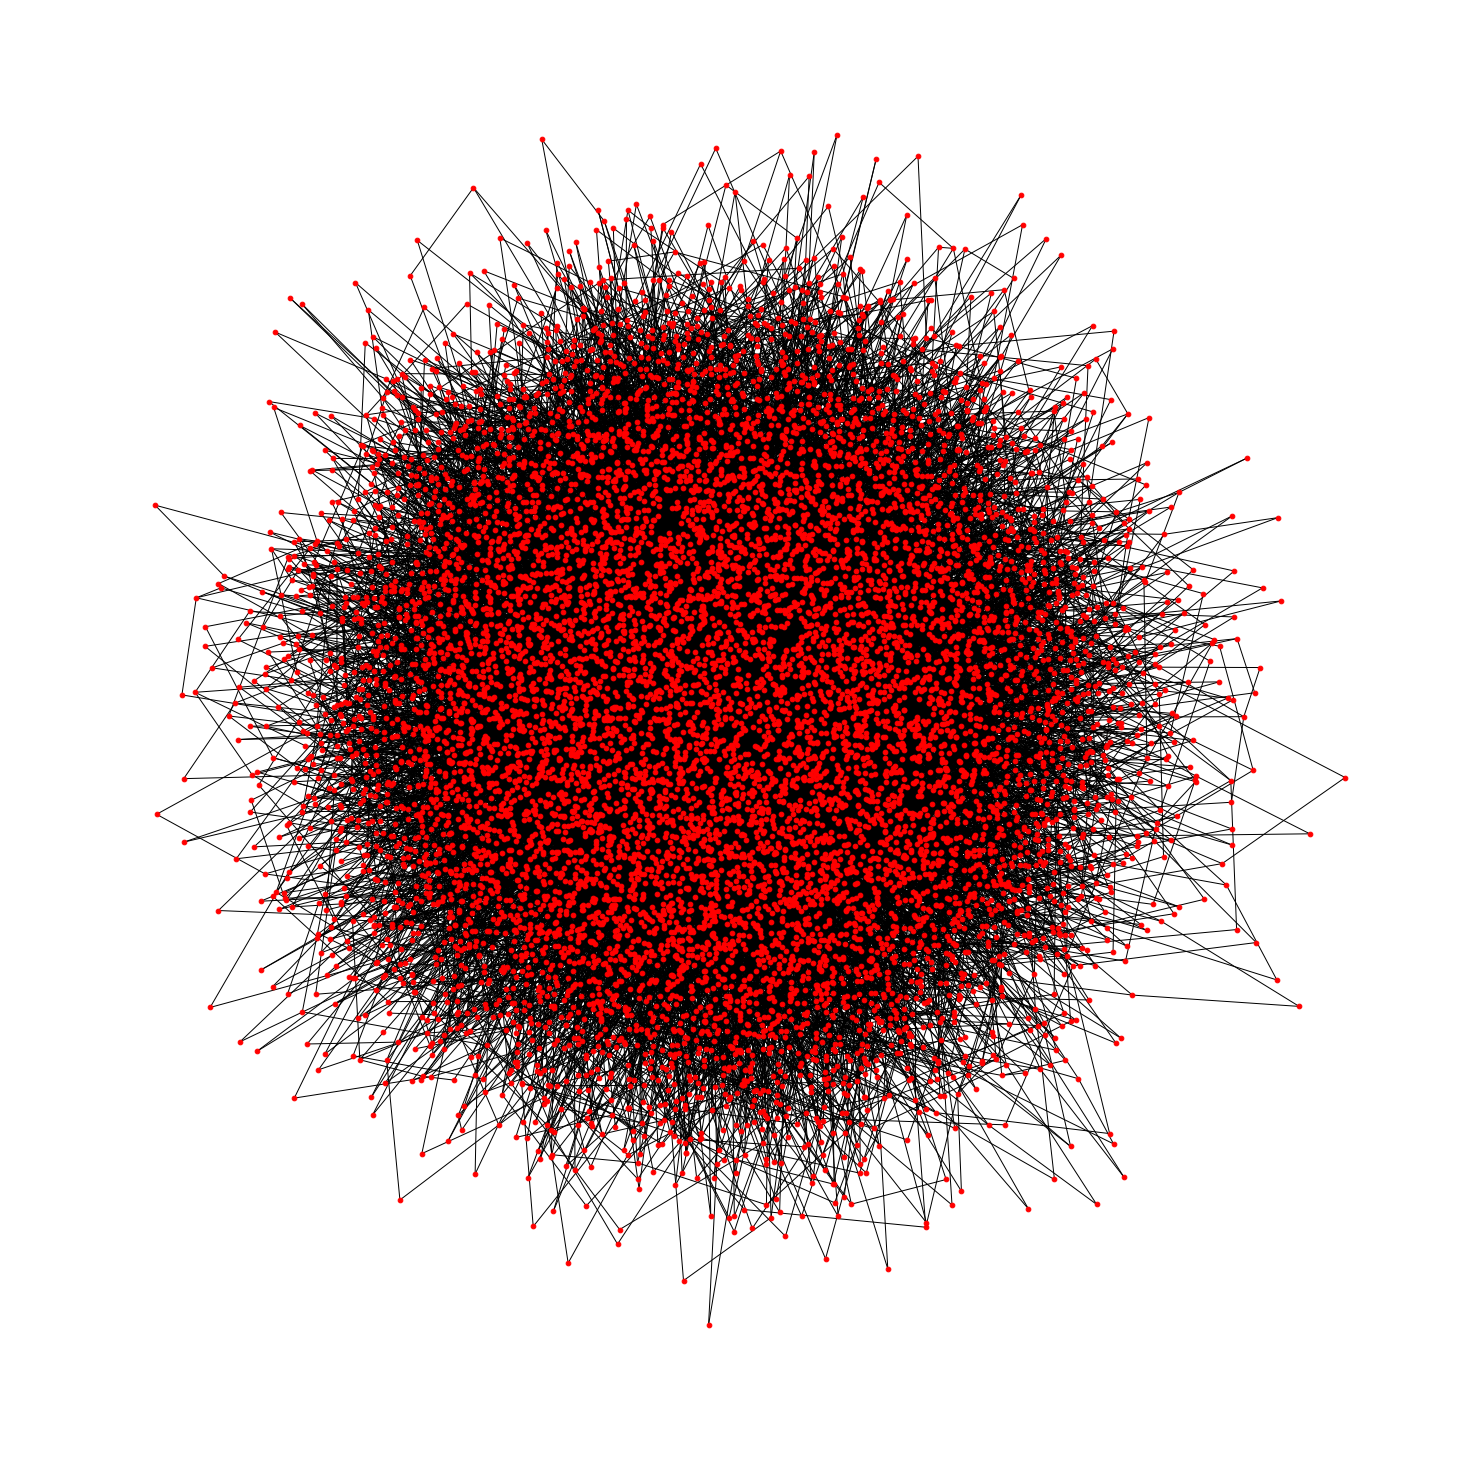

In [4]:
plt.figure(figsize=(20, 20))
nx.draw(baG, node_size=22)

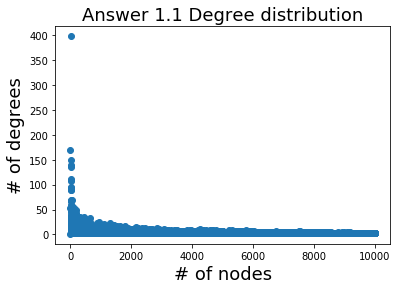

In [7]:
#Plot degree distribution.
degrees = nx.degree(baG)
dfDegrees = pd.DataFrame.from_dict(list(degrees.items()))
dfDegrees.columns = ["Node1","Count"]
dfDegrees.sort_values("Count",ascending=False)
plt.scatter(dfDegrees['Node1'],dfDegrees['Count']);
plt.xlabel('# of nodes', fontsize=18);
plt.ylabel('# of degrees', fontsize=18);
plt.title("Answer 1.1 Degree distribution",fontsize=18);

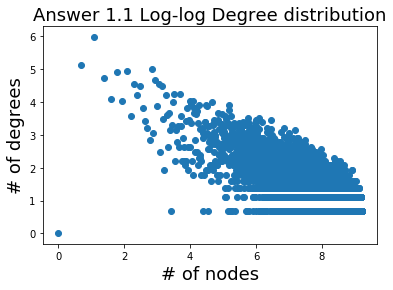

In [166]:
#Obtain a dictionary of nodes and count of their vertecies from graph. 
#Plot log-log plot of degree distribution.

degrees = nx.degree(baG)
dfDegrees = pd.DataFrame.from_dict(list(degrees.items()))
dfDegrees.columns = ["Node1","Count"]
dfDegrees.sort_values("Count",ascending=False)
plt.scatter(np.log(dfDegrees['Node1']),np.log(dfDegrees['Count']));
plt.xlabel('# of nodes', fontsize=18);
plt.ylabel('# of degrees', fontsize=18);
plt.title("Answer 1.1 Log-log Degree distribution",fontsize=18);

## Answer 1.2 Setup simulation

Simulation modified from given template by having three mods depending on the type of simulation ran. Mod1 as given, Mod2 with random immunization given fraction of nodes and Mod3 strategic immunization of nodes.

In [16]:
class SIRSimulator:
    def __init__(self, graph, beta=0.25, mu=0.05):
        self.g = graph   
        self.BETA = beta
        self.MU = mu
        
    def run(self, seed=[], num_steps=1, mod = 1, vacc=0.2, vacSet = set()):
        # if no seed is specified, choose 1 node at random
        if not len(seed):
            seed = [ np.random.choice(self.g.nodes()) ]
            
        # initialize sets of S/I/R nodes
        I_set = set(seed)
        
        if mod == 1:
            V_set = set()
            S_set = set(self.g.nodes()).difference(I_set)
        elif mod == 2:
            V_set = set()
            rem = set(self.g.nodes()).difference(I_set)
            for t1 in range(int(vacc * len(self.g.nodes()))):
                V_set.update(random.sample(set(rem),1))
            S_set = set(self.g.nodes()).difference(I_set.union(V_set))
        elif mod == 3:
            V_set = vacSet
            S_set = set(self.g.nodes()).difference(I_set.union(V_set))
        #else:
        #    mmm = 1
        
        R_set = set()
        t = 0
        
        StoI_set = set(seed) # nodes that underwent S->I transition
        ItoR_set = set() # nodes that underwent I->R transition
 
        while True:
            # generator logic: yield current status every num_steps iterations
            if t % num_steps == 0:
                yield { 't': t, 'S': S_set, 'V': V_set, 'I': I_set, 'R': R_set,
                       'S->I': StoI_set, 'I->R': ItoR_set }
            
            # stop when there are no infectious nodes left
            if not len(I_set):
                break

            StoI_set = set()
            ItoR_set = set()
            
            # loop over neighbors of infectious nodes
            for i in set(I_set):
                # TRANSMISSION
                for j in S_set.intersection(self.g.neighbors(i)):
                    if np.random.uniform() < self.BETA:
                        S_set.remove(j)
                        I_set.add(j)
                        StoI_set.add(j)
                        
                # RECOVERY
                if np.random.uniform() < self.MU:
                    I_set.remove(i)
                    R_set.add(i)
                    ItoR_set.add(i)
      
            t += 1

In [17]:
# Initialize SIR Simulatio with Barabasi-Albert graph and parameters which allow
# for easy take off of epidemic.
baSIR = SIRSimulator(baG, beta=0.6, mu=0.1)

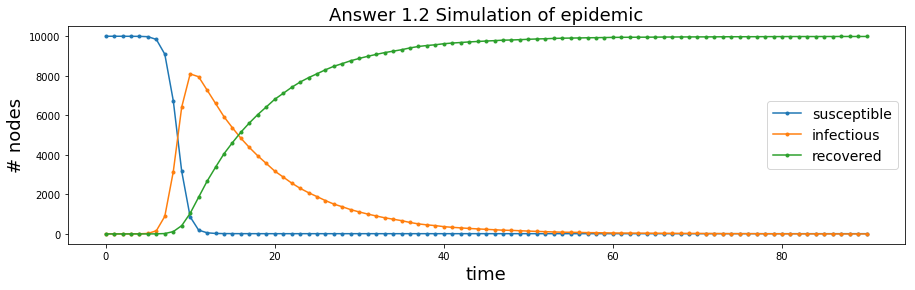

In [18]:
plt.figure(figsize=(15,4));
plt.plot([ (len(status['S']), len(status['I']),len(status['R'])) for status in baSIR.run(mod=1)], '.-');
plt.xlabel('time', fontsize=18);
plt.ylabel('# nodes', fontsize=18);
plt.legend(['susceptible', 'infectious', 'recovered'], fontsize=14, loc=7);
plt.title("Answer 1.2 Simulation of epidemic",fontsize=18);

Epidemic clearly took off and infected over 80% of population.

## Answer 1.3 Epidemic curves, attack ratio and peak infection boxplots

Ten epidemic simulations are run and number of nodes infected in each simulation ploted. Additionally, boxplots of attack rate and peak distribution.

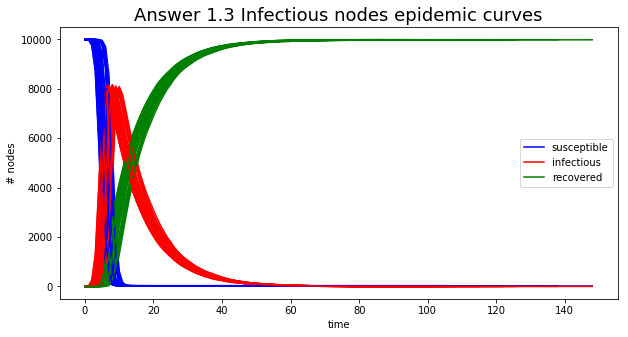

In [171]:
# Run 50 simulations and capture/plot epidemic curve.

attackRate = []
peak = []

plt.figure(figsize=(10,5))
for t in range(0,50):
    status_list = [(len(status['S']), len(status['I']), len(status['R'])) for status in baSIR.run(mod=1)]    
    S, I, R = [], [], []
    for j in status_list:
        S.append(j[0])
        I.append(j[1])
        R.append(j[2])
    
    attackRate.append(R[-1]/N)  
    peak.append(np.argmax(I)) 
 
    plt.plot(S, color = "blue")
    plt.plot(I, color = "red")
    plt.plot(R, color = "green")
    plt.xlabel('time')
    plt.ylabel('# nodes')
    plt.legend(['susceptible', 'infectious', 'recovered'], fontsize=10, loc='center right')
    plt.title("Answer 1.3 Infectious nodes epidemic curves",fontsize=18);

Epidemic takes off in each of the 50 simulations and infects 80% of population on average.

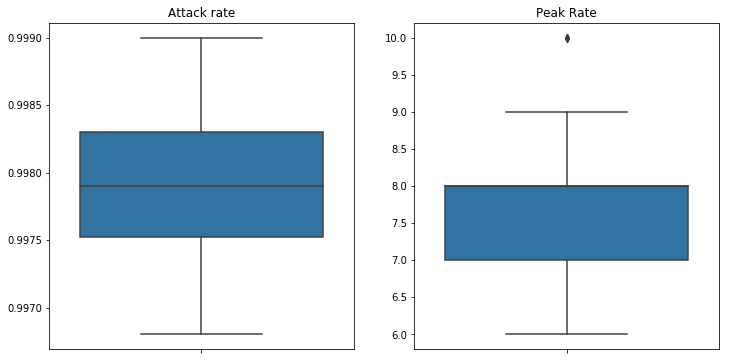

In [172]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('Attack rate')
sns.boxplot(attackRate, orient= 'v')
plt.subplot(122)
plt.title('Peak Rate')
sns.boxplot(peak, orient='v')
plt.show()

Attack rate (left plot) is very close to 1 because epidemic takes off and infects almost whole population. While peak rate (right plot) is 7.5 on average which indicates that epidemic takes off and progresses easily.

## PART 2: VACCINATION AND HERD IMMUNITY

## Answer 2.1 Upper bound of attack rate randomly immunizing fraction of nodes

$ \alpha $ = Attack Rate 

N = Total Nodes 

r = Fraction  of  immunized  nodes 

$$\alpha = \frac{N - (N*r)}{N}$$

In an example below 0.2 as r is chosen, N is the number of nodes in a graph and upper bound of attack rate is calculated.

In [177]:
#Example of upper bound calculation.
r = 0.2
N = len(baG.nodes())
bound = (N - int(r*N))/N
print('The upper bound is', np.round(bound,4))

The upper bound is 0.8


## Answer 2.2 Attack rate in randomly immunized Barabasi-Albert Graph

In [87]:
# Simulate SIR process 5 times for each fraction of r immunized nodes. Randomly immunized nodes. Collect number of 
# recovered nodes at the end of each process and divide it with N to obtain attack ratio.

a22_frac = [0.01, 0.1, 0.5, 0.8, 0.9]
a22_rVals = []
a22_rRatio = []
for frac in a22_frac:
    for k in range(50):
        for status in baSIR.run(mod=2,vacc=frac):
            a22_rec = len(status['R'])
        a22_rVals.append(a22_rec/10000)
    a22_rRatio.append(np.mean(a22_rVals))

In [88]:
a22_rRatio

[0.98736799999999991,
 0.93098199999999987,
 0.78521466666666673,
 0.6341635000000001,
 0.53246800000000005]

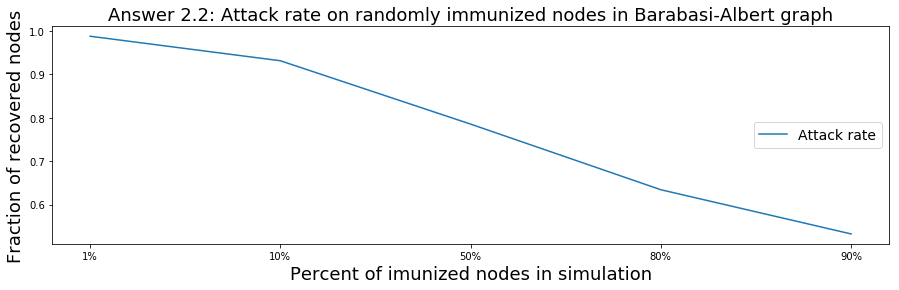

In [89]:
#Plotting, set the figure size, xlabel ticks, plot data, add title, x and y labels, legend

xLab = np.array(list(range(0, 5)))
xLab1 = ["1%","10%","50%","80%","90%"]
xLab1.sort()

plt.figure(figsize=(15,4))
plt.xticks(xLab, xLab1)
plt.plot(xLab,a22_rRatio);
plt.title('Answer 2.2: Attack rate on randomly immunized nodes in Barabasi-Albert graph', fontsize=18);
plt.xlabel('Percent of imunized nodes in simulation', fontsize=18);
plt.ylabel('Fraction of recovered nodes', fontsize=18);
plt.legend(['Attack rate'], fontsize=14, loc=7);

Attack rate shows a trendy continous decrease with the increase of umminized nodes, the initial uneven trend is due to the scale difference (1% vs 10% on the rest of the graph). Therefore immunization of population is crucial for prevention of epidemic and decrease of attack rate.

## Answer 2.3 Attack rate in randomly immunized Erdos-Renyi graph

In [112]:
p = nx.density(baG)
erG = nx.erdos_renyi_graph(10000, p)
print("Total # of nodes:", len(erG.nodes()))
print("Total # of edges:", len(erG.edges()))

Total # of nodes: 10000
Total # of edges: 19785


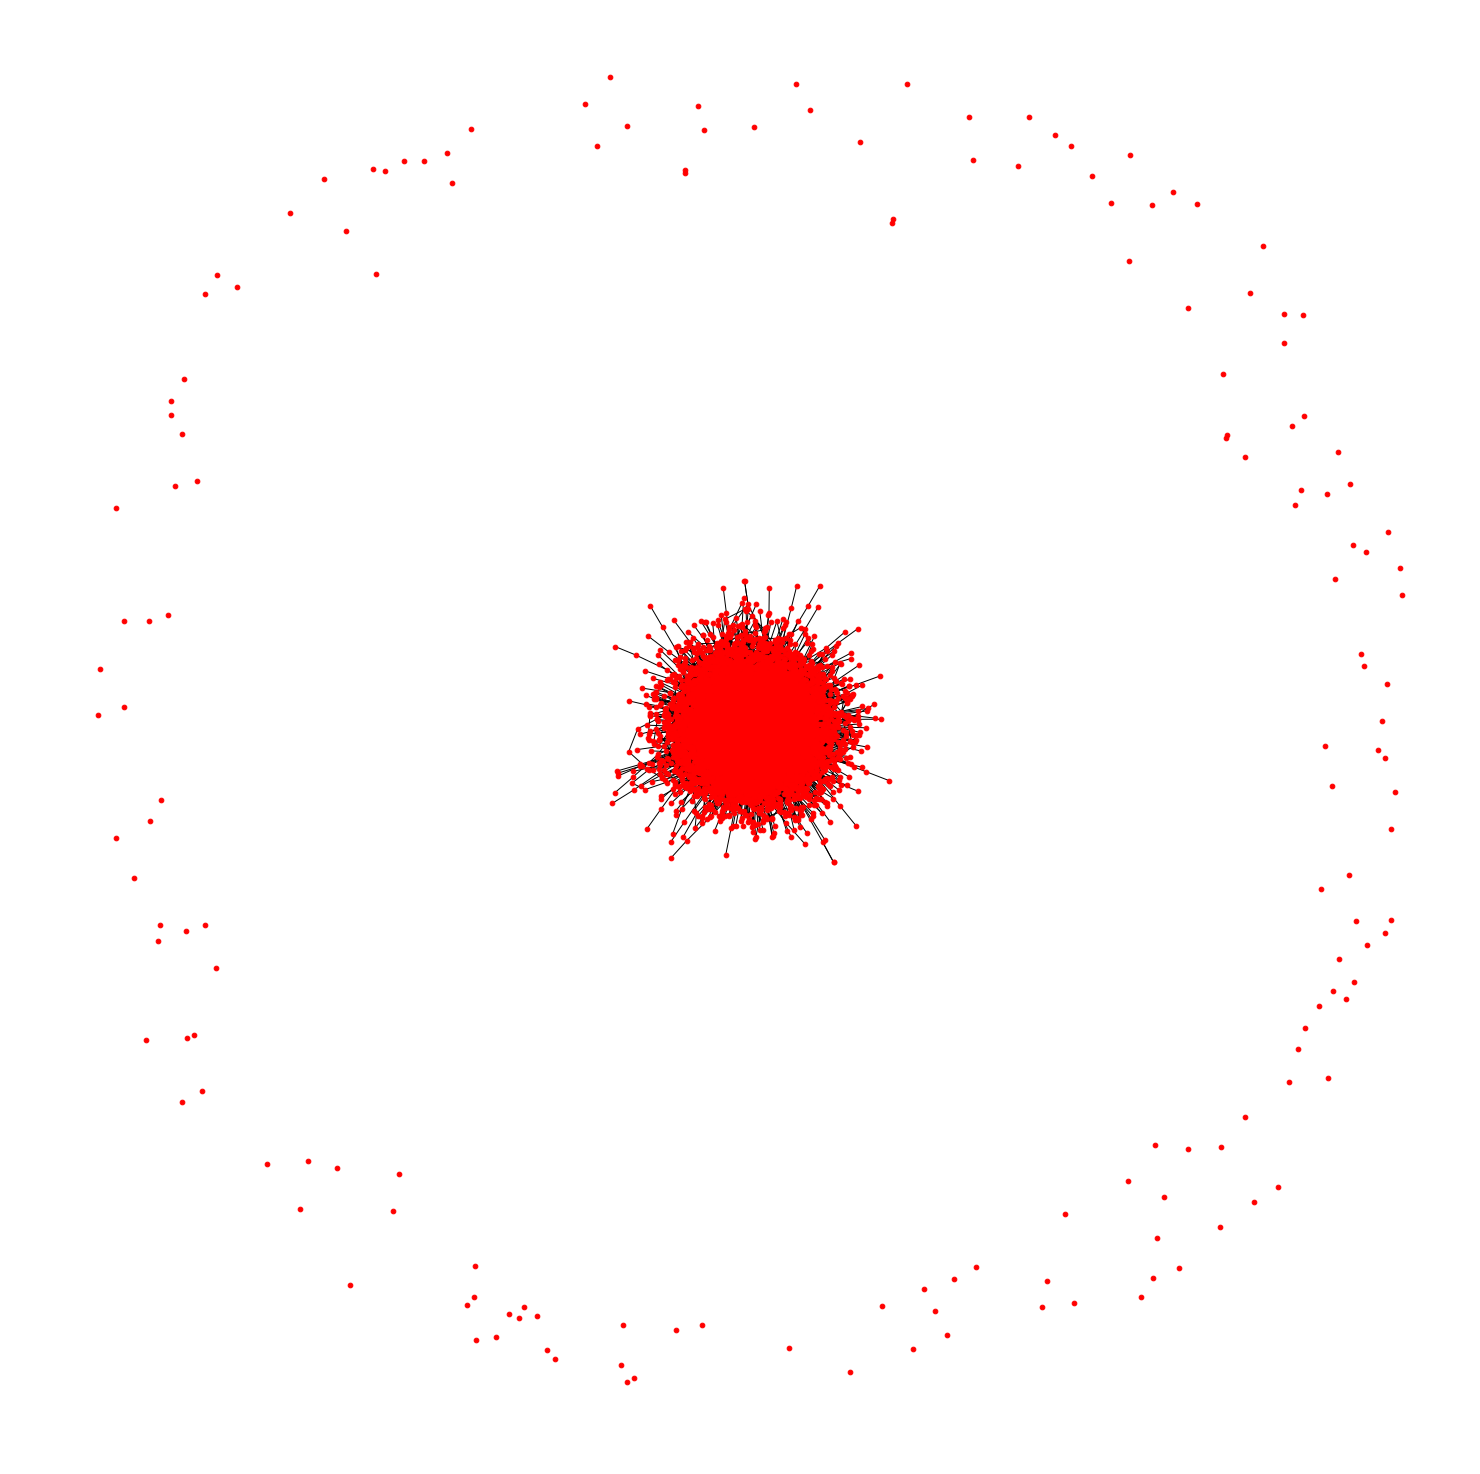

In [113]:
plt.figure(figsize=(20, 20))
nx.draw(erG, node_size=22)

Text(0,0.5,'# nodes')

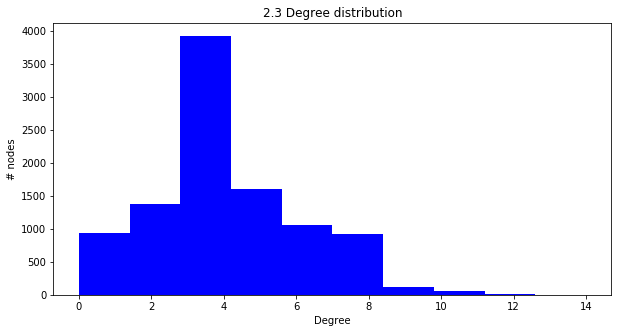

In [107]:
# Compute and plot the degree distribution
degrees = erG.degree().values()
plt.figure(figsize=(10,5))
plt.hist(list(degrees), color = 'blue', bins = 10)
plt.title('2.3 Degree distribution')
plt.xlabel('Degree')
plt.ylabel('# nodes')

In [115]:
# Simulate SIR process 5 times for each fraction of r immunized nodes. Randomly immunized nodes. Collect number of 
# recovered nodes at the end of each process and divide it with N to obtain attack ratio.
erSIR = SIRSimulator(erG, beta=0.6, mu=0.1)
a23_rValsER = []
a23_rRatioER = []
for frac in a22_frac:
    for k in range(5):
        for status in erSIR.run(mod=2,vacc=frac):
            a23_rec = len(status['R'])
        a23_rValsER.append(a23_rec/10000)
    a23_rRatioER.append(np.mean(a23_rValsER))

In [116]:
a23_rRatioER

[0.96636000000000011,
 0.83251000000000008,
 0.69423333333333337,
 0.58102999999999994,
 0.49371999999999999]

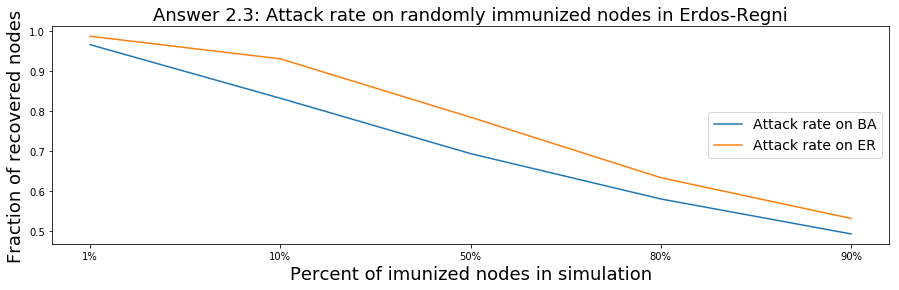

In [119]:
#Plotting, set the figure size, xlabel ticks, plot data, add title, x and y labels, legend
xLab = np.array(list(range(0, 5)))
xLab1 = ["1%","10%","50%","80%","90%"]
xLab1.sort()

plt.figure(figsize=(15,4))
plt.xticks(xLab, xLab1)
plt.plot(xLab,a23_rRatioER);
plt.plot(xLab,a22_rRatio);
plt.title('Answer 2.3: Attack rate on randomly immunized nodes in Erdos-Regni', fontsize=18);
plt.xlabel('Percent of imunized nodes in simulation', fontsize=18);
plt.ylabel('Fraction of recovered nodes', fontsize=18);
plt.legend(['Attack rate on BA','Attack rate on ER'], fontsize=14, loc=7);

The attack rates on Erdos-Regni graph are higher due to the fact that there is slightly lower number of connections than in Barabasi-Albert which allows us to prevent spreading of epidemic with immunization with greater efficiency.

## PART 3: TARGETED VACCINATION STRATEGIES

## Answer 3.1 Attack rate in strategically immunized Barabasi-Albert Graph

Strategy of immunizing nodes consists of each node being rated and sorted based on its connectedness ratio (neighbours/N).

In [120]:
#Build a dataframe of most connected nodes based on ratio neighbours/N, to be used as immunization base.
a31_mostConnNodes = []
for i in range(0,N):
    a31_mostConnNodes.append(len(baG.neighbors(i))/N)
a31_mostConnDf = pd.DataFrame({"Node":list(range(0, N)),"Ratio":a31_mostConnNodes})
a31_mostConnDf = a31_mostConnDf.sort_values("Ratio",ascending=False)
a31_mostConnDf.head()

,Node,Ratio
3,3,0.0398
2,2,0.0170
17,17,0.0150
8,8,0.0140
6,6,0.0136


In [188]:
# Simulate SIR process 50 times for each fraction of r immunized nodes. Select immunized nodes based on rated 
# nodes dataframe. Collect number of recovered nodes at the end of each process and divide it with N to obtain
# attack ratio.
a31_rVals = []
a31_rRatio = []
for frac in a22_frac:
    cnt = int(N*frac)
    md = a31_mostConnDf.iloc[0:cnt,0] 
    Vset = set(md)
    for k in range(50):
        for status in baSIR.run(mod=3,vacSet=Vset):
            rec = len(status['R'])
        a31_rVals.append(rec/10000)
    a31_rRatio.append(np.mean(a31_rVals))

In [189]:
a31_rRatio

[0.93993199999999999,
 0.62489800000000006,
 0.41665400000000002,
 0.31253199999999998,
 0.25004919999999997]

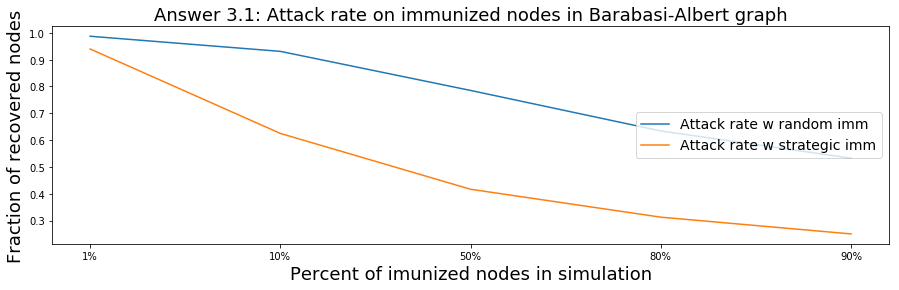

In [190]:
#Plotting, set the figure size, xlabel ticks, plot data, add title, x and y labels, legend
plt.figure(figsize=(15,4))
plt.xticks(xLab, xLab1)
plt.plot(xLab,a22_rRatio);
plt.plot(xLab,a31_rRatio);
plt.title('Answer 3.1: Attack rate on immunized nodes in Barabasi-Albert graph', fontsize=18);
plt.xlabel('Percent of imunized nodes in simulation', fontsize=18);
plt.ylabel('Fraction of recovered nodes', fontsize=18);
plt.legend(['Attack rate w random imm','Attack rate w strategic imm'], fontsize=14, loc=7);

Strategically immunizing network clearly has tremendeous improvement in stopping the epidemic as already on 10% of immunized nodes attack rate is significantly lowered, while at 50% immunization it is less than half of population. However the greatest drop of 30% is within the top 10% connected nodes since the further immunization does not yield similar decrease of attack rate. This indicates that top10% of nodes are significantly more connected than the rest of the nodes.

## Answer 3.2 Attack rate in inference-based immunized Barabasi-Albert Graph

Strategy of immunizing nodes consists of each node being rated and sorted based on the time it was infected, and how long it remained infected in each simulation. So a node that gets infected sooner and stays infected for more cycles than average is expected to rank higher than average.

In [126]:
#Build two counters, one to collect currently infected nodes in simulation and get multiplied by decreasing value
# as a proxy to time weighted rating and the other to keep cumulative value over time. Eventually move and sort
# results to data.frame which will serve as basis for selecting immunized nodes.
a32_c = collections.Counter()
a32_cCum = collections.Counter()

for t in range(0,20):
    i = 500
    for status in baSIR.run(mod=1):
            a32_c.update(status["I"])
            a32_cCum.update(list(a32_c.elements())*i)
            a32_c.clear()
            i = i - 10
            if i < 1:
                i = 1
a32_inferenceDf = pd.DataFrame.from_dict(a32_cCum, orient='index').reset_index()
a32_inferenceDf.columns = ["Node","Rating"]
a32_inferenceDf = a32_inferenceDf.sort_values("Rating",ascending=False)
a32_inferenceDf.head()

,Node,Rating
5160,5160,119349
3330,3330,112400
6398,6398,111290
8723,8723,110572
3548,3548,109230


In [191]:
# Simulate SIR process 50 times for each fraction of r immunized nodes. Select immunized nodes based on rated 
# nodes dataframe. Collect number of recovered nodes at the end of each process and divide it with N to obtain
# attack ratio.
a32_rVals = []
a32_rRatio = []
for frac in a22_frac:
    a32_cnt = int(N*frac)
    a32_md = a32_inferenceDf.iloc[0:a32_cnt,0] 
    Vset = set(a32_md)
    for k in range(50):
        for status in baSIR.run(mod=3,vacSet=Vset):
            rec = len(status['R'])
        a32_rVals.append(rec/10000)
    a32_rRatio.append(np.mean(a32_rVals))

In [192]:
a32_rRatio

[0.96728799999999993,
 0.92736600000000025,
 0.70735533333333322,
 0.53104750000000012,
 0.42487000000000008]

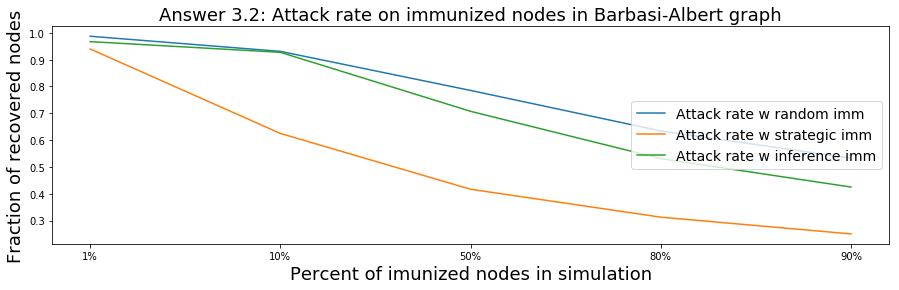

In [193]:
#Plotting, set the figure size, xlabel ticks, plot data, add title, x and y labels, legend
plt.figure(figsize=(15,4))
plt.xticks(xLab, xLab1)
plt.plot(xLab,a22_rRatio);
plt.plot(xLab,a31_rRatio);
plt.plot(xLab,a32_rRatio);
plt.title('Answer 3.2: Attack rate on immunized nodes in Barbasi-Albert graph', fontsize=18);
plt.xlabel('Percent of imunized nodes in simulation', fontsize=18);
plt.ylabel('Fraction of recovered nodes', fontsize=18);
plt.legend(['Attack rate w random imm','Attack rate w strategic imm', 'Attack rate w inference imm'], fontsize=14, loc=7);

The attack rate is clearly significantly lower when strategically immunizing nodes. Although inference based approach yeilds better results than random immunization.

## Answer 3.3 Attack rate in partial strategic immunized Barabasi-Albert Graph

The idea is same as in 3.1, K=10% of nodes are randomly selected and for each node number of neighbors is divided by total number of nodes to get ratio of connectedness. Ratio is sorted so that most connected nodes are at the top, and these nodes are immunized. 

In [206]:
# Simulate SIR process 50 times for each fraction of r immunized nodes. Select immunized nodes based on rated 
# nodes dataframe. Collect number of recovered nodes at the end of each process and divide it with N to obtain
# attack ratio.
# Build a dataframe of most connected nodes based on ratio neighbours/N, to be used as immunization base.
a33_is = random.sample(list(range(0,N)),10000)
a33_mostConnNodes = []
for i in a33_is:
    a33_mostConnNodes.append(len(baG.neighbors(i))/N)
a33_mostConnDf = pd.DataFrame({"Node":a33_is,"Ratio":a33_mostConnNodes})
a33_mostConnDf = a33_mostConnDf.sort_values("Ratio",ascending=False)
toAppend = set(set(baG.nodes())).difference(a33_mostConnDf["Node"])
a33_mostConnDf1 = a33_mostConnDf.append(pd.DataFrame({"Node":list(toAppend)}))
a33_rVals = []
a33_rRatio = []
for frac in a22_frac:
    a33_cnt = int(N*frac)
    a33_md = a33_mostConnDf1.iloc[0:a33_cnt,0] 
    Vset = set(a33_md)
    for k in range(50):
        for status in baSIR.run(mod=3,vacSet=Vset):
            rec = len(status['R'])
        a33_rVals.append((rec/10000))
    a33_rRatio.append(np.mean(a33_rVals))

In [207]:
a33_rRatio

[0.96825473684210517,
 0.62580421052631585,
 0.41726456140350882,
 0.31299368421052631,
 0.25041894736842107]

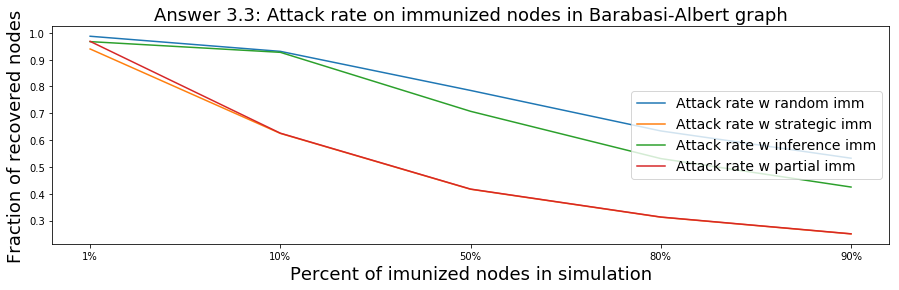

In [208]:
#Plotting, set the figure size, xlabel ticks, plot data, add title, x and y labels, legend

plt.figure(figsize=(15,4))
plt.xticks(xLab, xLab1)
plt.plot(xLab,a22_rRatio);
plt.plot(xLab,a31_rRatio);
plt.plot(xLab,a32_rRatio);
plt.plot(xLab,a33_rRatio);
plt.title('Answer 3.3: Attack rate on immunized nodes in Barabasi-Albert graph', fontsize=18);
plt.xlabel('Percent of imunized nodes in simulation', fontsize=18);
plt.ylabel('Fraction of recovered nodes', fontsize=18);
plt.legend(['Attack rate w random imm','Attack rate w strategic imm', 'Attack rate w inference imm',
            'Attack rate w partial imm'], fontsize=14, loc=7);

Strategic immunization of nodes remains the most effective way to prevent attack rate.